# Semantic Segmentation of satellite imagery using U-Net
## Step 1: Data preparation

Adapted from the [code by Dr. Sreenivas Bhattiprolu](https://github.com/bnsreenu/python_for_microscopists/tree/master/230_landcover_dataset_segmentation) (also see the [tutorial](https://www.youtube.com/watch?v=0W6MKZqSke8))

Dataset: https://www.kaggle.com/datasets/adrianboguszewski/landcoverai?resource=download

Tasks:

1. Read large images and corresponding masks, divide them into smaller patches and write the patches as image files to the local drive.

2. Save only images and masks where masks have a relevant amount of labels needed. In this case we are especially looking for building footprints, so images with 100% woodland don't help much.

3. Split the sorted dataset from above into train and validation datasets.

4. Move files to the correctly named directories for later use with ImageDataGenerator from keras.

To start, download the dataset and place the images and masks in the directories defined below as `dir_img` and `dir_masks`.

In [1]:
# Necessary because of a bug https://github.com/qubvel/segmentation_models/issues/374
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
import os
import shutil
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import splitfolders

In [3]:
# Add the parent directory to the path to make imports work
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import helper functions from files in src folder
from src import plot, prepare_data

#### Define directory paths

In [4]:
# Landcover AI base path
dir_data_landcover = Path("../data/landcover_ai/")

# We suppose that the Landcover AI images are stored in the following directories
dir_img = Path(dir_data_landcover, "images")
dir_mask = Path(dir_data_landcover, "masks")

# We will store the patches in the following directories
dir_patch = Path(dir_data_landcover, "patches")
dir_patch_img = Path(dir_patch, "images")
dir_patch_mask = Path(dir_patch, "masks")
dir_patch_useful_img = Path(dir_patch, "useful/images")
dir_patch_useful_mask = Path(dir_patch, "useful/masks")

# Define file paths for the inventory
inventory_path = Path(dir_data_landcover, "inventory.csv")
inventory_short_path = Path(dir_data_landcover, "inventory_short.csv")

# Create directories if they don't exist
for dir in [dir_data_landcover, dir_img, dir_mask]:
    Path(dir).mkdir(parents=True, exist_ok=True)

In [5]:
# Count the number of images and masks
n_images = len(list(dir_img.glob("*.tif")))
n_masks = len(list(dir_mask.glob("*.tif")))

if n_images == 0:
    print("No images found")
elif n_images != n_masks:
    print("Number of images and masks do not match")
else:
    print(f"Number of images: {n_images}")
    print(f"Number of masks: {n_masks}")

Number of images: 41
Number of masks: 41


In [6]:
classes = {0: "Not classified", 1: "Building", 2: "Woodland", 3: "Water", 4: "Roads"}

#### Visualize the three RGB bands of an image


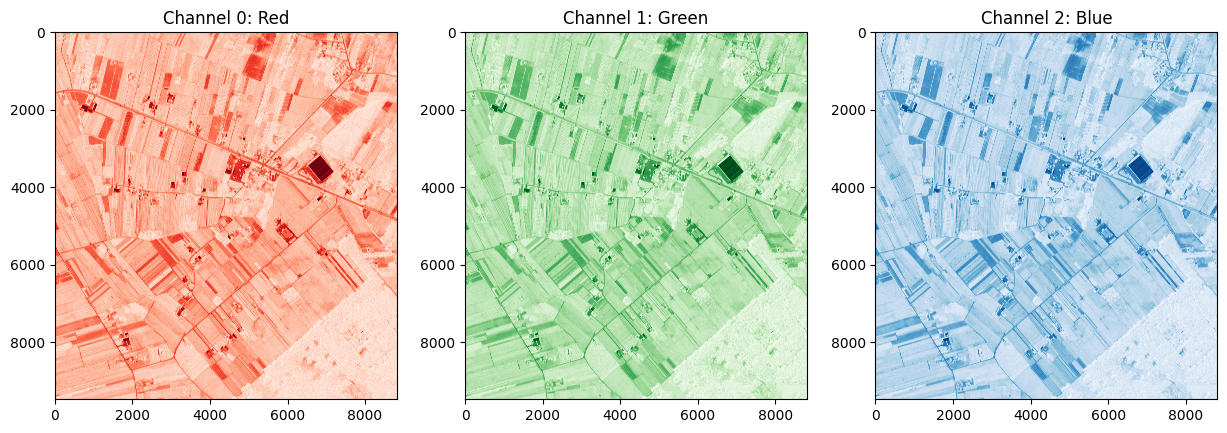

In [7]:
# Get paths of all images
img_files = [file for file in dir_img.iterdir()]

# Image with buildings
# img_path = Path(dir_img, "N-33-130-A-d-4-4.tif")

# Image with water
# img_path = Path(dir_img, "M-33-20-D-d-3-3.tif")

# Image with roads and buildings
img_path = Path(dir_img, "M-34-6-A-d-2-2.tif")

# Get random image from all images
# img_path = np.random.choice(img_files)

plot.plot_image_channels(img_path)

#### Visualize the mask for the same image


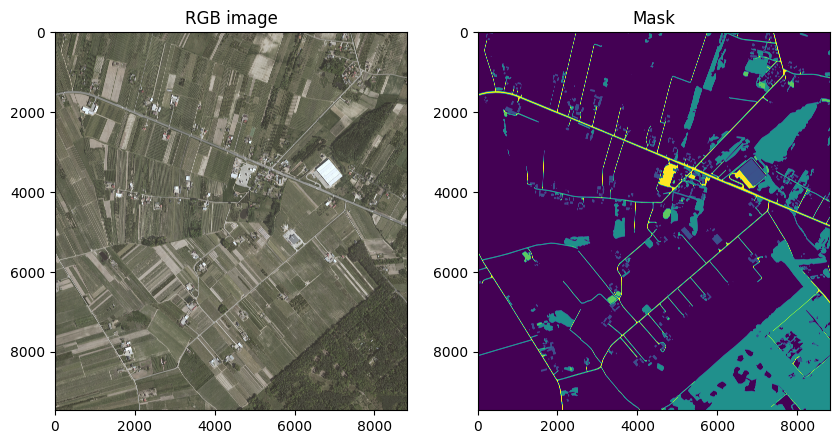

In [8]:
mask_path = Path(str(img_path).replace("/images/", "/masks/"))
plot.plot_image_and_mask(img_path, mask_path)

In [9]:
mask_path = Path(img_path.as_posix().replace("/images/", "/masks/"))
mask = cv2.imread(mask_path.as_posix())

# Can be checked for each channel. All channels are identical
labels, count = np.unique(mask[:, :, 0], return_counts=True)
print(
    f"Labels are:\n\n"
    f"{labels[0]}. Background: {count[0]:,} ({count[0]/np.sum(count):.2%})\n"
    f"{labels[1]}. Buildings: {count[1]:,} ({count[1]/np.sum(count):.2%})\n"
    f"{labels[2]}. Woodland: {count[2]:,} ({count[2]/np.sum(count):.2%})\n"
    f"{labels[3]}. Water: {count[3]:,} ({count[3]/np.sum(count):.2%})\n"
    f"{labels[4]}. Roads: {count[4]:,} ({count[4]/np.sum(count):.2%})"
)

Labels are:

0. Background: 68,643,142 (82.20%)
1. Buildings: 1,467,062 (1.76%)
2. Woodland: 10,910,421 (13.07%)
3. Water: 236,301 (0.28%)
4. Roads: 2,249,534 (2.69%)


### Crop each large image into patches of 256x256


In [10]:
# Create directories if they don't exist
for dir in [
    dir_patch,
    dir_patch_img,
    dir_patch_mask,
    dir_patch_useful_img,
    dir_patch_useful_mask,
]:
    Path(dir).mkdir(parents=True, exist_ok=True)

In [11]:
# Run the function to create patches for images
prepare_data.create_patches(dir_img, dir_patch_img)

Patchifying image: ../data/landcover_ai/images/N-33-139-C-d-2-2.tif
Created 1295 patches in ../data/landcover_ai/patches/images.
Skipped 0 already existing patches.
Patchifying image: ../data/landcover_ai/images/N-34-94-A-b-2-4.tif
Created 1258 patches in ../data/landcover_ai/patches/images.
Skipped 0 already existing patches.
Patchifying image: ../data/landcover_ai/images/N-33-139-C-d-2-4.tif
Created 1295 patches in ../data/landcover_ai/patches/images.
Skipped 0 already existing patches.
Patchifying image: ../data/landcover_ai/images/N-33-139-D-c-1-3.tif
Created 1295 patches in ../data/landcover_ai/patches/images.
Skipped 0 already existing patches.
Patchifying image: ../data/landcover_ai/images/N-33-104-A-c-1-1.tif
Created 1258 patches in ../data/landcover_ai/patches/images.
Skipped 0 already existing patches.
Patchifying image: ../data/landcover_ai/images/M-34-65-D-c-4-2.tif
Created 1260 patches in ../data/landcover_ai/patches/images.
Skipped 0 already existing patches.
Patchifying 

In [12]:
# Run the function to create patches for masks
prepare_data.create_patches(dir_mask, dir_patch_mask)

Patchifying image: ../data/landcover_ai/masks/N-33-139-C-d-2-2.tif
Created 1295 patches in ../data/landcover_ai/patches/masks.
Skipped 0 already existing patches.
Patchifying image: ../data/landcover_ai/masks/N-34-94-A-b-2-4.tif
Created 1258 patches in ../data/landcover_ai/patches/masks.
Skipped 0 already existing patches.
Patchifying image: ../data/landcover_ai/masks/N-33-139-C-d-2-4.tif
Created 1295 patches in ../data/landcover_ai/patches/masks.
Skipped 0 already existing patches.
Patchifying image: ../data/landcover_ai/masks/N-33-139-D-c-1-3.tif
Created 1295 patches in ../data/landcover_ai/patches/masks.
Skipped 0 already existing patches.
Patchifying image: ../data/landcover_ai/masks/N-33-104-A-c-1-1.tif
Created 1258 patches in ../data/landcover_ai/patches/masks.
Skipped 0 already existing patches.
Patchifying image: ../data/landcover_ai/masks/M-34-65-D-c-4-2.tif
Created 1260 patches in ../data/landcover_ai/patches/masks.
Skipped 0 already existing patches.
Patchifying image: ../da

### Create patch inventory


In [13]:
inventory = prepare_data.create_patch_inventory(dir_patch_mask, inventory_path, classes)

Saved patch inventory to ../data/landcover_ai/inventory.csv
Shorter version saved to ../data/landcover_ai/inventory_short.csv


In [14]:
inventory

,img,0,1,2,3,4,total,0_pct,1_pct,2_pct,3_pct,4_pct,useful_pct
0,M-34-65-D-a-4-4_patch_30_12.tif,1659.0,0.0,194949.0,0.0,0.0,196608,0.008438,0.000000,0.991562,0.000000,0.000000,0.991562
1,M-34-5-D-d-4-2_patch_6_4.tif,1218.0,0.0,195390.0,0.0,0.0,196608,0.006195,0.000000,0.993805,0.000000,0.000000,0.993805
2,M-34-6-A-d-2-2_patch_31_29.tif,9645.0,0.0,185259.0,0.0,1704.0,196608,0.049057,0.000000,0.942276,0.000000,0.008667,0.950943
3,M-33-20-D-d-3-3_patch_23_21.tif,183270.0,10137.0,3201.0,0.0,0.0,196608,0.932159,0.051559,0.016281,0.000000,0.000000,0.067841
4,M-34-65-D-c-4-2_patch_15_31.tif,0.0,0.0,196608.0,0.0,0.0,196608,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44117,M-34-65-D-a-4-4_patch_29_13.tif,5391.0,0.0,191217.0,0.0,0.0,196608,0.027420,0.000000,0.972580,0.000000,0.000000,0.972580
44118,N-34-106-A-c-1-3_patch_29_2.tif,191193.0,0.0,147.0,5268.0,0.0,196608,0.972458,0.000000,0.000748,0.026794,0.000000,0.027542
44119,M-34-65-D-a-4-4_patch_16_9.tif,156831.0,0.0,29433.0,0.0,10344.0,196608,0.797684,0.000000,0.149704,0.000000,0.052612,0.202316
44120,N-34-140-A-b-4-2_patch_16_10.tif,178659.0,0.0,17949.0,0.0,0.0,196608,0.908707,0.000000,0.091293,0.000000,0.000000,0.091293


### Select patches containing relevant information

Copy patches and masks with real information to a new folder.


In [15]:
prepare_data.select_useful_patches(
    dir_patch_img,
    dir_patch_mask,
    dir_patch_useful_img,
    dir_patch_useful_mask,
    inventory_short_path,
    classes,
)

Added 1000 images with class 1.
Added 1000 images with class 3.
Added 1000 images with class 4.
3000 useful images in list.
0 missing in source.
3000 copied.


### Visualize classes in patches

In [16]:
inventory_useful = prepare_data.create_patch_inventory(
    dir_patch_useful_mask,
    Path(dir_data_landcover, "inventory_useful.csv"),
    classes,
    force=True,
)

Saved patch inventory to ../data/landcover_ai/inventory_useful.csv
Shorter version saved to ../data/landcover_ai/inventory_useful_short.csv


Text(0.5, 1.0, 'Roads')

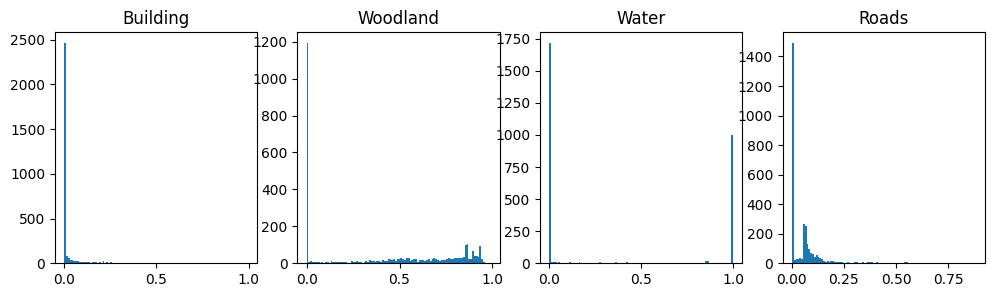

In [17]:
# Plot a histograms in subplots for 1_pct, 2_pct, 3_pct, 4_pct in inventory_useful
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
axs[0].hist(inventory_useful["1_pct"], bins=100)
axs[0].set_title(classes[1])
axs[1].hist(inventory_useful["2_pct"], bins=100)
axs[1].set_title(classes[2])
axs[2].hist(inventory_useful["3_pct"], bins=100)
axs[2].set_title(classes[3])
axs[3].hist(inventory_useful["4_pct"], bins=100)
axs[3].set_title(classes[4])

In [18]:
# # Remove other classes from selected patches
# for file in dir_patch_useful_mask.iterdir():
#     mask = cv2.imread(file.as_posix())
#     mask[mask == 2] = 0
#     mask[mask == 3] = 0
#     mask[mask == 4] = 0
#     cv2.imwrite(file.as_posix(), mask)

### Plot random patch alongside its mask


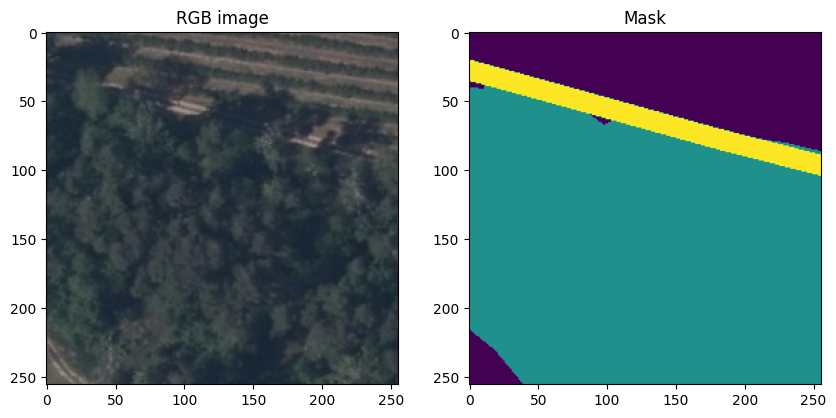

In [19]:
# Get paths of all patches
patch_files = [file for file in dir_patch_useful_img.iterdir()]

# Randomly select one of them
patch_path = np.random.choice(patch_files)

mask_path = Path(str(patch_path).replace("/images/", "/masks/"))

plot.plot_image_and_mask(patch_path, mask_path)

### Split the data into training, validation and testing


In [20]:
input_folder = Path(dir_patch, "useful")
output_folder = Path(dir_data_landcover, "tmp")

# Delete output_folder if it exists
if output_folder.is_dir():
    shutil.rmtree(str(output_folder))

for dir in [input_folder, output_folder]:
    Path(dir).mkdir(parents=True, exist_ok=True)

# Split with a ratio
# To only split into training and validation set, set a tuple to ratio, i.e, `(.8, .2)`.
splitfolders.ratio(
    input_folder, output=output_folder, seed=42, ratio=(0.75, 0.25), group_prefix=None
)

Copying files: 6000 files [00:00, 10318.47 files/s]


### Move files to final destination


In [21]:
move_files = {
    "train/images/": "train_images/train/",
    "train/masks/": "train_masks/train/",
    "val/images/": "val_images/val/",
    "val/masks/": "val_masks/val/",
}

for source, dest in move_files.items():
    source = Path(output_folder, source)
    dest = Path(dir_data_landcover, dest)

    # Delete destination if it exists
    if dest.is_dir():
        shutil.rmtree(str(dest))

    # Make sure destination exists
    Path(dest).mkdir(parents=True, exist_ok=True)

    counter = 0

    for file in source.iterdir():
        if file.is_file():
            file.rename(Path(dest, file.name))
            counter += 1

    print(f"Moved {counter} files from {source} to {dest}.")

Moved 2250 files from ../data/landcover_ai/tmp/train/images to ../data/landcover_ai/train_images/train.
Moved 2250 files from ../data/landcover_ai/tmp/train/masks to ../data/landcover_ai/train_masks/train.
Moved 750 files from ../data/landcover_ai/tmp/val/images to ../data/landcover_ai/val_images/val.
Moved 750 files from ../data/landcover_ai/tmp/val/masks to ../data/landcover_ai/val_masks/val.


### Remove temporary directory


In [22]:
files_left = 0

# Count number of files left
for file in output_folder.rglob("*"):
    if file.is_file():
        files_left += 1

if files_left == 0:
    shutil.rmtree(output_folder)
    print(f"Removed empty directory {output_folder}.")
else:
    print(f"{output_folder} not empty, did not remove.")

Removed empty directory ../data/landcover_ai/tmp.
